In [ ]:
!pip install onnx onnxruntime
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import hdbscan
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest

from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

from google.colab import files

In [ ]:
def differentiable_intersection(meas):
    """
    meas: Tensor, shape [N, 4] - [x0, y0, cos, sin]
    Returns: [2] tensor (x, y)
    """
    x0 = meas[:, 0]
    y0 = meas[:, 1]
    dx = meas[:, 2]
    dy = meas[:, 3]
    dirs = torch.stack([dx, dy], dim=1)
    dirs = F.normalize(dirs, p=2, dim=1)
    # Each line: (x, y) = (x0, y0) + t * (dx, dy)
    # For each, build normal vector: [-dy, dx] (orthogonal)
    # For least squares, minimize orthogonal distances
    normals = torch.stack([-dirs[:, 1], dirs[:, 0]], dim=1)  # [N,2]
    # Build least squares system: normals @ [x, y] = normals @ [x0, y0]
    A = normals    # [N,2]
    b = (normals * torch.stack([x0, y0], dim=1)).sum(1)  # [N]
    # Least squares solution: x = (A^T A)^-1 A^T b
    x_hat, *_ = torch.linalg.lstsq(A, b.unsqueeze(1))
    return x_hat.squeeze(1)


def geometric_consistency_loss(meas, pred_labels, true_targets, n_clusters):
    """
    meas: [N,4] tensor
    pred_labels: [N] numpy array (from clustering, -1 for outliers)
    true_targets: [K,2] tensor
    n_clusters: int
    Returns: geometric loss (MSE) as a differentiable tensor
    """
    cluster_centers = []
    for c in range(n_clusters):
        inds = (pred_labels == c).nonzero()[0] if isinstance(pred_labels, np.ndarray) else (pred_labels == c).nonzero(as_tuple=True)[0]
        if len(inds) < 2:
            cluster_centers.append(torch.tensor([float('nan'), float('nan')], device=meas.device))
            continue
        cluster_meas = meas[inds]
        center = differentiable_intersection(cluster_meas)
        cluster_centers.append(center)
    cluster_centers = torch.stack(cluster_centers, dim=0)
    # Remove clusters that couldn't be estimated
    mask = ~torch.isnan(cluster_centers).any(dim=1)
    cluster_centers = cluster_centers[mask]
    if cluster_centers.shape[0] == 0 or true_targets.shape[0] == 0:
        return torch.tensor(0.0, device=meas.device)
    # Assignment (Hungarian, differentiable proxy: minimal sum over all perms)
    # For few clusters, just brute-force all permutations:
    from itertools import permutations
    K = cluster_centers.shape[0]
    perms = list(permutations(range(K)))
    min_loss = None
    for perm in perms:
        # Permute predicted cluster centers to true target order
        diff = cluster_centers[list(perm)] - true_targets[:K]
        mse = (diff ** 2).sum(1).mean()
        if min_loss is None or mse < min_loss:
            min_loss = mse
    return min_loss


def geometric_angular_error_loss(meas, pred_labels, true_targets, n_clusters):
    """
    meas: [N,4] tensor (x, y, cos, sin)
    pred_labels: [N] numpy or torch array (cluster for each DOA)
    true_targets: [K,2] tensor (true positions)
    n_clusters: int

    Returns: mean absolute angular error [rad]
    """
    total_err = 0.0
    total_count = 0
    from itertools import permutations
    # Get predicted centers (as before, or just use assigned targets)
    for perm in permutations(range(min(true_targets.shape[0], n_clusters))):
        perm_err = 0.0
        count = 0
        for k, t_idx in enumerate(perm):
            # All DOAs assigned to cluster k
            inds = (pred_labels == k).nonzero()[0] if isinstance(pred_labels, np.ndarray) else (pred_labels == k).nonzero(as_tuple=True)[0]
            if len(inds) == 0:
                continue
            # True target assigned to this cluster
            target = true_targets[t_idx]  # [2]
            sensor_pos = meas[inds, :2]   # [M,2]
            true_dir = target[None, :] - sensor_pos  # [M,2]
            true_dir = true_dir / (np.linalg.norm(true_dir, axis=1, keepdims=True) + 1e-8)  # [M,2]
            pred_dir = meas[inds, 2:4]   # [M,2] (already unit vector)
            # Angular error = arccos(dot)
            dots = (pred_dir * true_dir).sum(axis=1)
            dots = np.clip(dots, -1.0, 1.0)
            ang_err = np.arccos(dots)
            perm_err += np.sum(ang_err)
            count += len(inds)
        if count > 0:
            perm_err /= count
            if total_count == 0 or perm_err < total_err:
                total_err = perm_err
                total_count = count
    return torch.tensor(total_err if total_count > 0 else 0.0, device=meas.device)


In [ ]:
# --- Parameters ---
NUM_SENSORS = 10
GRID_SIZE = 10
NOISE_STD = 2.5
EMBED_DIM = 8
NHEAD = 4
NUM_LAYERS = 4  # increased depth for better context modeling

In [ ]:
# Set seed
seed = 420
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

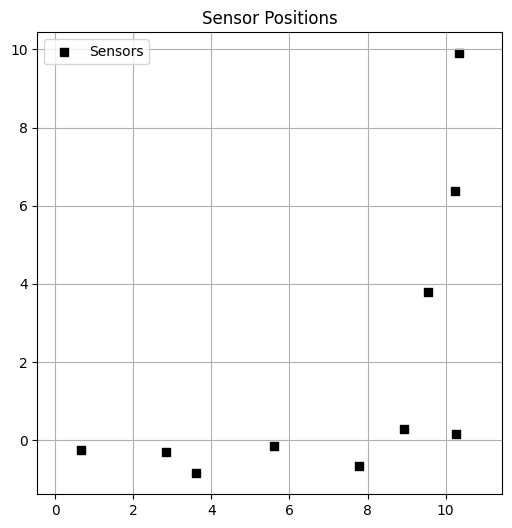

In [ ]:
# Create grid for training
# Fixed sensor positions
SENSOR_POSITIONS = []
GRID_X = np.linspace(0, GRID_SIZE, 500)
GRID_Y = np.linspace(0, GRID_SIZE, 500)
train_targets_grid = [(x, y) for x in GRID_X for y in GRID_Y]

# Create L-shape sensor array (right and below the grid) with noise
num_right = NUM_SENSORS // 2 - 1
num_bottom = NUM_SENSORS - num_right
pos_std = 0.5
right_x = np.full(num_right, GRID_SIZE + 0.5) + np.random.normal(0, pos_std, num_right)
right_y = np.linspace(0, GRID_SIZE, num_right) + np.random.normal(0, pos_std, num_right)
bottom_x = np.linspace(0, GRID_SIZE, num_bottom) + np.random.normal(0, pos_std, num_bottom)
bottom_y = np.full(num_bottom, -0.5) + np.random.normal(0, pos_std, num_bottom)
SENSOR_POSITIONS = np.column_stack([
    np.concatenate([right_x, bottom_x]),
    np.concatenate([right_y, bottom_y])
])
# Plot sensor positions
plt.figure(figsize=(6, 6))
plt.scatter(SENSOR_POSITIONS[:, 0], SENSOR_POSITIONS[:, 1], c='black', marker='s', label='Sensors')
plt.title("Sensor Positions")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [ ]:
def generate_scene_from_targets(
    sensors,
    target_list,
    noise_std=2.5,
    p_miss=0.3,
    p_false=0.2,
    single_per_sensor_ratio=0.6
):
    """
    ... (docstring unchanged)
    Returns:
        measurements: (n_meas, 4)
        labels:       (n_meas,)  target index or -1 for outlier
        target_list:  (n_targets, 2)
        sensor_ids:   (n_meas,)  which sensor index each measurement is from
        true_angles:  (n_meas,)  azimuth in radians (true angle, before noise for inliers, actual for outliers)
    """
    measurements = []
    labels = []
    sensor_ids = []
    true_angles = []

    n_targets = len(target_list)
    for s_idx, sensor in enumerate(sensors):
        if n_targets == 2 and np.random.rand() < single_per_sensor_ratio:
            t_idx = np.random.randint(0, 2)
            if np.random.rand() > p_miss:
                vec = target_list[t_idx] - sensor
                azimuth = np.arctan2(vec[1], vec[0])
                noisy_azimuth = azimuth + np.radians(np.random.randn() * noise_std)
                angle = [np.cos(noisy_azimuth), np.sin(noisy_azimuth)]
                measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                labels.append(t_idx)
                sensor_ids.append(s_idx)
                true_angles.append(azimuth)  # store true angle
            if np.random.rand() < p_false:
                min_angle_diff = np.radians(8)
                attempts = 0
                while True:
                    outlier_angle = np.random.uniform(-np.pi, np.pi)
                    vecs = target_list - sensor
                    target_angles = np.arctan2(vecs[:, 1], vecs[:, 0])
                    diffs = np.abs(np.unwrap(target_angles - outlier_angle))
                    if np.all(diffs > min_angle_diff) or attempts > 50:
                        break
                    attempts += 1
                angle = [np.cos(outlier_angle), np.sin(outlier_angle)]
                measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                labels.append(-1)
                sensor_ids.append(s_idx)
                true_angles.append(outlier_angle)  # store actual outlier angle
        else:
            for t_idx, target in enumerate(target_list):
                if np.random.rand() > p_miss:
                    vec = target - sensor
                    azimuth = np.arctan2(vec[1], vec[0])
                    noisy_azimuth = azimuth + np.radians(np.random.randn() * noise_std)
                    angle = [np.cos(noisy_azimuth), np.sin(noisy_azimuth)]
                    measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                    labels.append(t_idx)
                    sensor_ids.append(s_idx)
                    true_angles.append(azimuth)
                if np.random.rand() < p_false:
                    min_angle_diff = np.radians(8)
                    attempts = 0
                    while True:
                        outlier_angle = np.random.uniform(-np.pi, np.pi)
                        vecs = target_list - sensor
                        target_angles = np.arctan2(vecs[:, 1], vecs[:, 0])
                        diffs = np.abs(np.unwrap(target_angles - outlier_angle))
                        if np.all(diffs > min_angle_diff) or attempts > 50:
                            break
                        attempts += 1
                    angle = [np.cos(outlier_angle), np.sin(outlier_angle)]
                    measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                    labels.append(-1)
                    sensor_ids.append(s_idx)
                    true_angles.append(outlier_angle)

    return (
        np.array(measurements),
        np.array(labels),
        np.array(target_list),
        np.array(sensor_ids),
        np.array(true_angles),
    )


# ---- Generate Test Scene ----

def generate_train_scene(epoch=0, max_epochs=100, min_noise=2.0, max_noise=10.0):
    """
    Generates one training scene, with noise_std scheduled between min_noise and max_noise over epochs.
    """
    num_targets = random.choice([1, 2])
    targets = random.sample(train_targets_grid, num_targets)

    # Progressive noise schedule
    frac = min(epoch / max_epochs, 1.0)
    noise_std = min_noise + (max_noise - min_noise) * frac

    measurements, labels, target_list, sensor_ids, true_angles =  generate_scene_from_targets(
        SENSOR_POSITIONS, targets,
        noise_std=noise_std,
        single_per_sensor_ratio=0.6
    )

    return measurements, labels, target_list, sensor_ids, num_targets, true_angles

In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
    def forward(self, x):  # x: [B, N, 2]
        device = x.device
        pos = x[:, :, :2]  # [B, N, 2]
        div_term = torch.exp(torch.arange(0, self.d_model, 2, device=device) * (-np.log(10000.0) / self.d_model))
        pe = torch.zeros(x.shape[0], x.shape[1], self.d_model, device=device)
        pe[:, :, 0::2] = torch.sin(pos[:, :, 0:1] * div_term)
        pe[:, :, 1::2] = torch.cos(pos[:, :, 1:2] * div_term)
        return pe



class DOAEncoder(nn.Module):
    def __init__(self, input_dim=4, embed_dim=8, nhead=4, num_layers=4, n_clusters=2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, embed_dim)
        self.input_norm = nn.LayerNorm(embed_dim)
        self.pos_encoder = SinusoidalPositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            batch_first=True,
            dropout=0.2,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.Tanh()
        )
        self.outlier_head = nn.Linear(embed_dim, 1)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.target_count_head = nn.Linear(embed_dim, 2)
        # ---- Cluster head for DeepCluster/KMeans assignment ----
        self.cluster_head = nn.Linear(embed_dim, n_clusters)

    def forward(self, x, sensor_ids=None, return_attention=False):
        B, N, _ = x.shape
        inp = self.input_fc(x)
        pos = self.pos_encoder(x)
        x = self.input_norm(inp + pos)
        cls_token = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls_token, x], dim=1)
        if sensor_ids is not None:
            sid = sensor_ids
            sid_cls = torch.full((B, 1), -1, dtype=sid.dtype, device=sid.device)
            sid = torch.cat([sid_cls, sid], dim=1)
            mask = (sid[0].unsqueeze(0) == sid[0].unsqueeze(1))
        else:
            mask = None
        x = self.transformer(x, mask=mask)
        emb = self.output_fc(x[:, 1:])
        emb = F.normalize(emb, p=2, dim=-1)
        outlier_score = self.outlier_head(emb).squeeze(-1)
        cls_emb = x[:, 0]
        target_count_pred = self.target_count_head(cls_emb).squeeze(0)
        return emb, outlier_score, target_count_pred

    def cluster_logits(self, emb):
        """For DeepCluster pseudo-label loss."""
        return self.cluster_head(emb)


In [ ]:
def cross_entropy(logits, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(- target * F.log_softmax(logits, -1), -1))
    else:
        return torch.sum(torch.sum(- target * F.log_softmax(logits, -1), -1))


class NpairLoss(nn.Module):
    """the multi-class n-pair loss"""
    def __init__(self, l2_reg=0.02):
        super(NpairLoss, self).__init__()
        self.l2_reg = l2_reg

    def forward(self, anchor, positive, target):
        batch_size = anchor.size(0)
        target = target.view(target.size(0), 1)

        target = (target == torch.transpose(target, 0, 1)).float()
        target = target / torch.sum(target, dim=1, keepdim=True).float()

        logit = torch.matmul(anchor, torch.transpose(positive, 0, 1))
        loss_ce = cross_entropy(logit, target)
        l2_loss = torch.sum(anchor**2) / batch_size + torch.sum(positive**2) / batch_size

        loss = loss_ce + self.l2_reg*l2_loss*0.25
        return loss

npair_loss = NpairLoss(l2_reg=0.02)


In [ ]:
def get_true_targets_for_scene(meas, lbls, target_list):
    # target_list is (n_targets, 2), as returned by generate_scene_from_targets
    return torch.tensor(target_list, dtype=torch.float32)

def train_model_geometric(
    model,
    device,
    epochs=10,
    num_scenes=1000,
    min_noise=0.5,
    max_noise=3.0,
    geom_loss_weight=0.1
):
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=num_scenes,
        epochs=epochs,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4,
    )

    if not hasattr(model, 'cluster_head'):
        embed_dim = model.output_fc[0].out_features if hasattr(model, 'output_fc') else model.embed_dim
        model.cluster_head = nn.Linear(embed_dim, 2).to(device)  # 2 = max clusters

    total_losses, cluster_losses, outlier_head_losses, cls_losses, geom_losses = [], [], [], [], []

    model.train()
    for epoch in range(epochs):
        all_embeds = []
        all_indices = []
        scene_data = []

        for scene_idx in range(num_scenes):
            # Return: measurements, labels, target_list, sensor_ids, num_targets, true_angles
            meas, lbls, target_list, sids, num_targets, true_angles = generate_train_scene(
                epoch=epoch,
                max_epochs=epochs,
                min_noise=min_noise,
                max_noise=max_noise
            )
            # Everything to device
            x = torch.tensor(meas, dtype=torch.float32, device=device).unsqueeze(0)
            y = torch.tensor(lbls, dtype=torch.long, device=device)
            sensor_ids = torch.tensor(sids, dtype=torch.long, device=device)
            emb, outlier_score, target_count_pred = model(x, sensor_ids=sensor_ids.unsqueeze(0))
            emb = emb[0].detach().cpu().numpy()  # We'll use KMeans on CPU
            mask = (lbls != -1)
            all_embeds.append(emb[mask])
            all_indices.extend([(scene_idx, i) for i, m in enumerate(mask) if m])
            scene_data.append((meas, lbls, target_list, sids, num_targets))

        if len(all_embeds) == 0:
            print("No inlier embeddings found!")
            continue
        all_embeds = np.vstack(all_embeds)
        kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
        cluster_assignments = kmeans.fit_predict(all_embeds)

        cluster_ptr = 0
        total_loss = 0
        sum_cluster_loss = 0
        sum_outlier_loss = 0
        sum_cls_loss = 0
        sum_geom_loss = 0
        n_batches = 0
        correct_count_pred = 0
        total_count_pred = 0
        total_true_1target = 0
        correct_1target = 0

        for scene_idx, (meas, lbls, target_list, sids, num_targets) in enumerate(scene_data):
            # To device
            x = torch.tensor(meas, dtype=torch.float32, device=device).unsqueeze(0)
            y = torch.tensor(lbls, dtype=torch.long, device=device)
            sensor_ids = torch.tensor(sids, dtype=torch.long, device=device)
            emb, outlier_score, target_count_pred = model(x, sensor_ids=sensor_ids.unsqueeze(0))
            emb = emb[0]
            outlier_score = outlier_score[0]
            mask = (y != -1)
            pos = emb[mask]
            n_inliers = mask.sum().item()
            if n_inliers == 0:
                scheduler.step()
                continue
            cl_labels = torch.tensor(
                cluster_assignments[cluster_ptr:cluster_ptr + n_inliers],
                dtype=torch.long, device=device
            )
            cluster_ptr += n_inliers
            logits = model.cluster_head(pos)
            cluster_loss = F.cross_entropy(logits, cl_labels)

            outlier_target = (y == -1).float().to(device)
            bce_loss = nn.BCEWithLogitsLoss()
            outlier_head_loss = bce_loss(outlier_score, outlier_target)
            total_outlier_loss = 0.5 * outlier_head_loss

            count_target_class = torch.tensor(num_targets - 1, dtype=torch.long, device=device)
            ce_loss = nn.CrossEntropyLoss()
            cls_loss = ce_loss(target_count_pred.unsqueeze(0), count_target_class.unsqueeze(0))
            total_cls_loss = 0.15 * cls_loss

            # Geometric loss (differentiable)
            meas_tensor = torch.tensor(meas, dtype=torch.float32, device=device)
            true_targets = get_true_targets_for_scene(meas, lbls, target_list).to(device)
            geom_loss = geometric_consistency_loss(meas_tensor, cl_labels, true_targets, 2)
            total_geom_loss = geom_loss_weight * geom_loss

            loss = cluster_loss + total_outlier_loss + total_cls_loss + total_geom_loss

            pred_target_count = np.argmax(target_count_pred.detach().cpu().numpy()) + 1
            if pred_target_count == num_targets:
                correct_count_pred += 1
            total_count_pred += 1
            if num_targets == 1:
                total_true_1target += 1
                if pred_target_count == 1:
                    correct_1target += 1

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            sum_cluster_loss += cluster_loss.item()
            sum_outlier_loss += outlier_head_loss.item()
            sum_cls_loss += cls_loss.item()
            sum_geom_loss += geom_loss.item() if hasattr(geom_loss, 'item') else float(geom_loss)
            n_batches += 1

        avg_loss = total_loss / max(1, n_batches)
        avg_cluster = sum_cluster_loss / max(1, n_batches)
        avg_outlier = sum_outlier_loss / max(1, n_batches)
        avg_cls = sum_cls_loss / max(1, n_batches)
        avg_geom = sum_geom_loss / max(1, n_batches)
        acc = 100.0 * correct_count_pred / max(1, total_count_pred)
        acc_1target = 100.0 * correct_1target / max(1, total_true_1target) if total_true_1target > 0 else float('nan')
        print(
            f"Epoch {epoch+1}, Loss: {avg_loss:.4f} | "
            f"Cluster: {avg_cluster:.4f} | Outlier: {avg_outlier:.4f} | Cls: {avg_cls:.4f} | Geom: {avg_geom:.4f} | "
            f"Target count acc: {acc:.1f}% | "
            f"1-target: {correct_1target}/{total_true_1target} correct ({acc_1target:.1f}%)"
        )

        total_losses.append(avg_loss)
        cluster_losses.append(avg_cluster)
        outlier_head_losses.append(avg_outlier)
        cls_losses.append(avg_cls)
        geom_losses.append(avg_geom)

    plt.figure(figsize=(9,5))
    plt.plot(total_losses, label='Total Loss', linewidth=2)
    plt.plot(cluster_losses, label='Cluster Assign Loss')
    plt.plot(outlier_head_losses, label='Outlier Head Loss')
    plt.plot(cls_losses, label='Count Head Loss')
    plt.plot(geom_losses, label='Geometric Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Convergence of Loss Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def train_model(
    model,
    device,
    epochs=10,
    num_scenes=1000,
    min_noise=0.5,
    max_noise=3.0,
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=num_scenes,
        epochs=epochs,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=1e4,
    )

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        n_batches = 0
        correct_count_pred = 0
        total_count_pred = 0
        total_true_1target = 0
        correct_1target = 0

        for _ in range(num_scenes):
            # Progressive noise
            meas, lbls, _, sids, num_targets = generate_train_scene(
                epoch=epoch,
                max_epochs=epochs,
                min_noise=min_noise,
                max_noise=max_noise
            )
            x = torch.tensor(meas, dtype=torch.float32).unsqueeze(0).to(device)
            y = torch.tensor(lbls, device=device)
            sensor_ids = torch.tensor(sids, device=device)
            # Forward pass
            emb, outlier_score, target_count_pred = model(x, sensor_ids=sensor_ids.unsqueeze(0))
            emb = emb[0]
            outlier_score = outlier_score[0]
            emb = F.normalize(emb, p=2, dim=-1)

            mask = (y != -1)
            pos = emb[mask]
            pos_labels = y[mask].to(pos.device)
            pos_sids = sensor_ids[mask].to(pos.device)
            N = pos.shape[0]
            if N < 2:
                scheduler.step()
                continue

            # --- Pairwise losses ---
            eye_mask = ~torch.eye(N, dtype=bool, device=pos.device)
            same_target = (pos_labels.unsqueeze(0) == pos_labels.unsqueeze(1)) & (pos_sids.unsqueeze(0) != pos_sids.unsqueeze(1))
            same_sensor = (pos_sids.unsqueeze(0) == pos_sids.unsqueeze(1)) & eye_mask
            diff_target = (pos_labels.unsqueeze(0) != pos_labels.unsqueeze(1)) & (pos_labels.unsqueeze(0) != -1) & (pos_labels.unsqueeze(1) != -1)

            dmat = torch.cdist(pos, pos, p=2)  # [N, N]

            attract_loss = (dmat.pow(2) * same_target).sum()
            attract_count = same_target.sum().item()

            repel_sensor_loss = (F.relu(1.0 - dmat).pow(2) * same_sensor).sum()
            repel_sensor_count = same_sensor.sum().item()

            repel_target_loss = (F.relu(1.0 - dmat).pow(2) * diff_target).sum()
            repel_target_count = diff_target.sum().item()

            loss = 0
            count = 0
            if attract_count > 0:
                loss += attract_loss / attract_count
                count += 1
            if repel_sensor_count > 0:
                loss += repel_sensor_loss / repel_sensor_count
                count += 1
            if repel_target_count > 0:
                loss += repel_target_loss / repel_target_count
                count += 1
            if count > 0:
                loss = loss / count
            else:
                scheduler.step()
                continue

            # --- Outlier repulsion ---
            outlier_mask = (y == -1)
            inlier_mask = (y != -1)
            outliers = emb[outlier_mask]
            inliers = emb[inlier_mask]
            if outliers.shape[0] > 0 and inliers.shape[0] > 0:
                o_mat = outliers.unsqueeze(1)
                i_mat = inliers.unsqueeze(0)
                outlier_dists = torch.cdist(o_mat, i_mat).reshape(-1)
                outlier_loss = F.relu(1.5 - outlier_dists).pow(2).mean()
                loss += outlier_loss

            # --- Outlier head BCE loss ---
            outlier_target = (y == -1).float().to(outlier_score.device)
            bce_loss = nn.BCEWithLogitsLoss()
            outlier_head_loss = bce_loss(outlier_score, outlier_target)
            loss += 0.5 * outlier_head_loss

            # --- Target count head CE loss ---
            count_target_class = torch.tensor([num_targets - 1], dtype=torch.long, device=target_count_pred.device)
            ce_loss = nn.CrossEntropyLoss()
            cls_loss = ce_loss(target_count_pred.unsqueeze(0), count_target_class)
            loss += 0.15 * cls_loss

            # --- Target count accuracy tracking ---
            pred_target_count = np.argmax(target_count_pred.detach().cpu().numpy()) + 1
            if pred_target_count == num_targets:
                correct_count_pred += 1
            total_count_pred += 1
            if num_targets == 1:
                total_true_1target += 1
                if pred_target_count == 1:
                    correct_1target += 1

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / max(1, n_batches)
        acc = 100.0 * correct_count_pred / max(1, total_count_pred)
        acc_1target = 100.0 * correct_1target / max(1, total_true_1target) if total_true_1target > 0 else float('nan')
        print(
            f"Epoch {epoch+1}, Loss: {avg_loss:.4f} | "
            f"Target count acc: {acc:.1f}% | "
            f"1-target: {correct_1target}/{total_true_1target} correct ({acc_1target:.1f}%)"
        )


In [ ]:
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np

def emb_to_labels(emb, target_count_pred, method="gmm"):
    """
    emb: (N, D)
    target_count_pred: int, number of clusters
    method: "gmm" | "kmeans" | "hdbscan"
    """
    emb_norm = normalize(emb)
    iso = IsolationForest(contamination=0.1, random_state=42)
    outlier_pred = iso.fit_predict(emb_norm)
    inlier_mask = (outlier_pred == 1)
    emb_inliers = emb_norm[inlier_mask]
    final_labels = np.full(len(emb), -1)  # -1 = outlier

    match method.lower():
        case "gmm":
            clusterer = GaussianMixture(n_components=target_count_pred, covariance_type='diag', random_state=42)
            clust_labels = clusterer.fit_predict(emb_inliers)
        case "kmeans":
            clusterer = KMeans(n_clusters=target_count_pred, n_init=10, random_state=42)
            clust_labels = clusterer.fit_predict(emb_inliers)
        case "hdbscan":
            import hdbscan
            # Use min_cluster_size based on number of inliers/targets
            min_cluster_size = 3
            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
            clust_labels = clusterer.fit_predict(emb_inliers)
            # HDBSCAN may return -1 for outliers among inliers
            # Remap: outlier in inliers gets -1, clusters get 0,1,...
            # Outliers already -1 in final_labels, so safe to proceed
        case _:
            raise ValueError(f"Unknown clustering method: {method}")

    final_labels[inlier_mask] = clust_labels
    return final_labels


In [ ]:
def evaluate(
    model,
    sensors,         # (n_sensors, 2)
    sensors_ids,     # (n_measurements,)
    meas,            # (n_measurements, 4)
    lbls,            # (n_measurements,)
    targets,         # (n_targets, 2)
    cluster_method="gmm",  # "gmm", "kmeans", "hdbscan"
    contamination=0.1
):
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import normalize
    from sklearn.ensemble import IsolationForest
    from sklearn.manifold import TSNE

    # Forward pass
    x = torch.tensor(meas, dtype=torch.float32).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        emb, outlier_score, target_count_pred = model(x)
        emb = emb[0].cpu().numpy()                # [N, D]
        outlier_score = outlier_score[0].cpu().numpy()   # [N]
        target_count_pred = target_count_pred.cpu().numpy() # [2] logits

    # Print target count prediction
    pred_target_count = np.argmax(target_count_pred) + 1
    print(f"Predicted number of targets: {pred_target_count}")
    print("Outlier scores (sigmoid):", 1/(1+np.exp(-outlier_score)))

    # --- Outlier detection ---
    emb_norm = normalize(emb)
    clf = IsolationForest(contamination=contamination, random_state=42)
    is_outlier = clf.fit_predict(emb_norm) == -1

    # --- Clustering ---
    pred_labels = emb_to_labels(emb, np.max(lbls+1), method=cluster_method)
    pred_labels[is_outlier] = -1

    # --- Plot DOAs colored by predicted cluster ---
    plt.figure(figsize=(8, 6))
    for i, (x0, y0, dx, dy) in enumerate(meas):
        color = 'red' if pred_labels[i] == -1 else plt.cm.tab10(pred_labels[i] % 10)
        style = '--' if pred_labels[i] == -1 else '-'
        plt.plot([x0, x0 + 10*dx], [y0, y0 + 10*dy], linestyle=style, color=color, alpha=0.7)
    plt.scatter(sensors[:,0], sensors[:,1], c='black', marker='s', label='Sensors')
    plt.scatter(targets[:,0], targets[:,1], c='gold', marker='*', s=400, label='Targets')
    plt.title("DOAs colored by predicted cluster")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot DOAs colored by true label ---
    plt.figure(figsize=(8, 6))
    for lbl in np.unique(lbls):
        idxs = np.where(lbls == lbl)[0]
        label_name = "Outlier" if lbl == -1 else f"Target {lbl}"
        color = 'red' if lbl == -1 else plt.cm.tab10(lbl % 10)
        style = '--' if lbl == -1 else '-'
        for i in idxs:
            x0, y0, dx, dy = meas[i]
            plt.plot([x0, x0 + 10*dx], [y0, y0 + 10*dy], linestyle=style, color=color, alpha=0.7)
        # Correctly highlight sensors corresponding to these measurements:
        plt.scatter(sensors[sensors_ids[idxs], 0], sensors[sensors_ids[idxs], 1], marker='s', edgecolors='k', facecolors='none')
    plt.scatter(sensors[:,0], sensors[:,1], c='black', marker='s', label='Sensors', zorder=10)
    plt.scatter(targets[:,0], targets[:,1], c='gold', marker='*', s=400, label='Targets', zorder=10)
    plt.title("DOAs colored by true label")
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot t-SNE of embeddings colored by true label ---
    emb_2d = TSNE(n_components=2, perplexity=5, init='pca', learning_rate='auto', random_state=42).fit_transform(emb)
    plt.figure(figsize=(6, 6))
    for lbl in np.unique(lbls):
        pts = emb_2d[lbls == lbl]
        ids = sensors_ids[lbls == lbl]
        label_name = "Outlier" if lbl == -1 else f"Target {lbl}"
        for i, (x_, y_) in enumerate(pts):
            plt.text(x_, y_, str(ids[i]), fontsize=8, alpha=0.6)
        plt.scatter(pts[:, 0], pts[:, 1], label=label_name)
    plt.title("t-SNE of Embedding Space (Colored by True Labels)")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()


Epoch 1, Loss: 39.9789 | Cluster: 0.6508 | Outlier: 0.5871 | Cls: 0.7453 | Geom: 389.2279 | Target count acc: 50.3% | 1-target: 283/509 correct (55.6%)
Epoch 2, Loss: 13.5553 | Cluster: 0.3383 | Outlier: 0.4735 | Cls: 0.7375 | Geom: 128.6970 | Target count acc: 47.9% | 1-target: 206/493 correct (41.8%)
Epoch 3, Loss: 6.7922 | Cluster: 0.2540 | Outlier: 0.4258 | Cls: 0.7039 | Geom: 62.1966 | Target count acc: 49.2% | 1-target: 204/490 correct (41.6%)
Epoch 4, Loss: 3.8762 | Cluster: 0.1474 | Outlier: 0.3645 | Cls: 0.6959 | Geom: 34.4225 | Target count acc: 53.0% | 1-target: 339/506 correct (67.0%)
Epoch 5, Loss: 81.9336 | Cluster: 0.0384 | Outlier: 0.3145 | Cls: 0.7013 | Geom: 816.3271 | Target count acc: 49.2% | 1-target: 239/495 correct (48.3%)
Epoch 6, Loss: 29.6722 | Cluster: 0.0193 | Outlier: 0.2913 | Cls: 0.6970 | Geom: 294.0278 | Target count acc: 51.2% | 1-target: 238/480 correct (49.6%)
Epoch 7, Loss: 102.2592 | Cluster: 0.0115 | Outlier: 0.2681 | Cls: 0.6987 | Geom: 1020.0879 

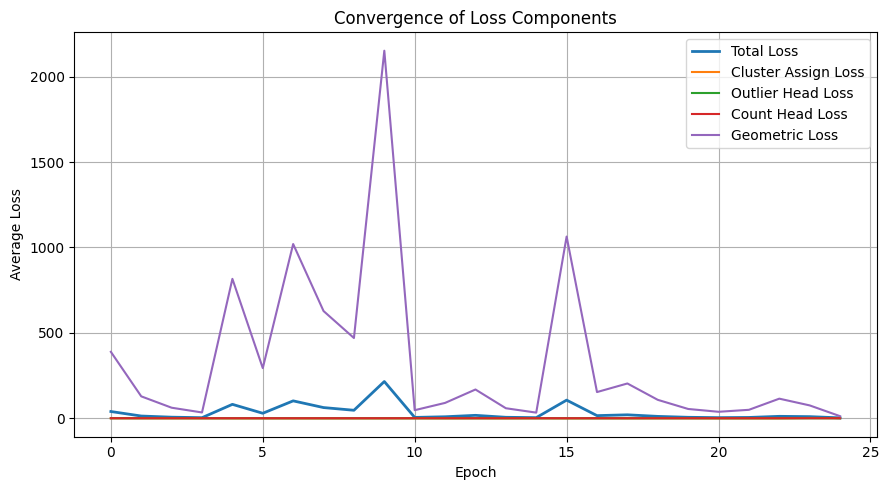

In [ ]:
# ---- Run ----
model = DOAEncoder(embed_dim=2*EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS).to(device)
train_model_geometric(model, device, epochs=25)

In [ ]:
# Set seed
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Predicted number of targets: 2
Outlier scores (sigmoid): [0.02909175 0.02869987 0.02929652 0.02955017 0.02961103 0.0288171
 0.03060333 0.02904981 0.03006882 0.02910221 0.02887593 0.02924285
 0.0280791  0.02945953 0.02870003 0.02877177]


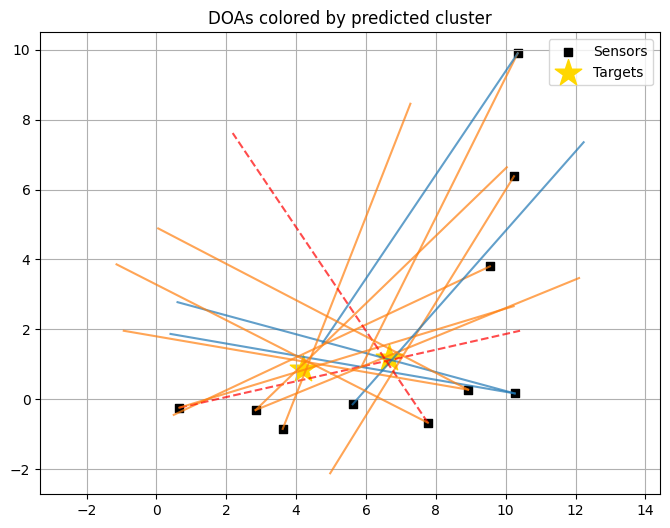

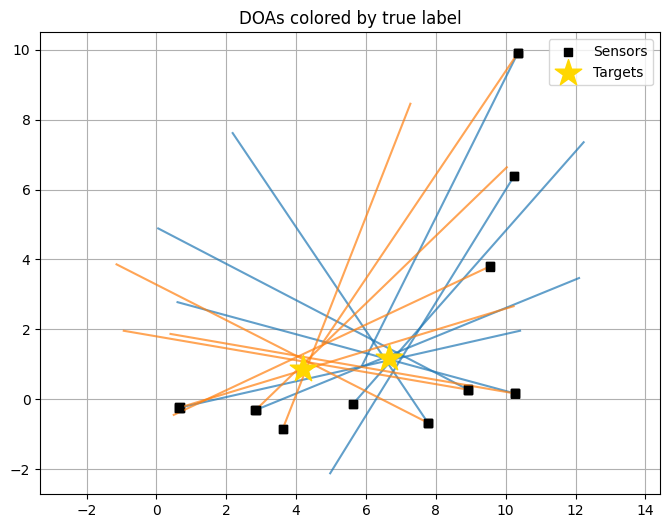

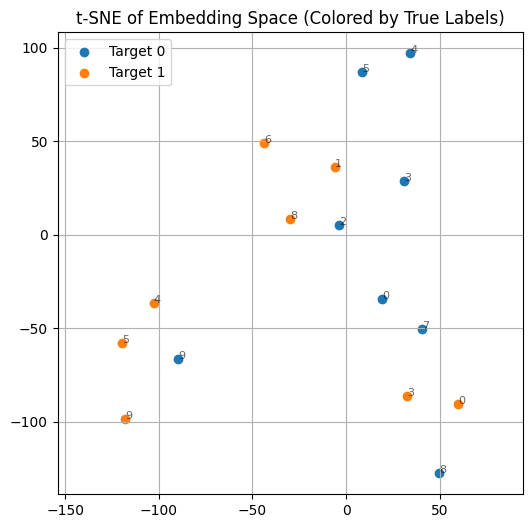

In [ ]:
# --- Test Case: On-grid or Off-grid Targets ---

test_num_targets = 2  # Or 1, as you wish
is_test_on_grid = True  # Set per test case

if is_test_on_grid:
    # Uniformly sample inside the grid (with margin 0.5 units)
    test_targets = np.random.uniform(0.5, GRID_SIZE - 0.5, size=(test_num_targets, 2))
else:
    # Sample outside the grid: randomly choose a side and sample just outside
    test_targets = []
    for _ in range(test_num_targets):
        side = np.random.choice([0, 1, 2, 3])
        if side == 0:  # left
            x = np.random.uniform(-2, 0)
            y = np.random.uniform(-1, GRID_SIZE + 1)
        elif side == 1:  # right
            x = np.random.uniform(GRID_SIZE, GRID_SIZE + 2)
            y = np.random.uniform(-1, GRID_SIZE + 1)
        elif side == 2:  # bottom
            x = np.random.uniform(-1, GRID_SIZE + 1)
            y = np.random.uniform(-2, 0)
        else:  # top
            x = np.random.uniform(-1, GRID_SIZE + 1)
            y = np.random.uniform(GRID_SIZE, GRID_SIZE + 2)
        test_targets.append([x, y])
    test_targets = np.array(test_targets)

# Generate measurements for this test scene
test_meas, test_lbls, test_targets, test_sensor_ids, _ = generate_scene_from_targets(
    SENSOR_POSITIONS, test_targets, noise_std=2.5, p_miss=0.3, p_false=0, single_per_sensor_ratio=0.1
)


# Evaluate
evaluate(model, SENSOR_POSITIONS, test_sensor_ids, test_meas, test_lbls, test_targets, cluster_method="gmm")


In [ ]:
# Save model to ONNX
import torch.onnx
onnx_path = "doa_sinusoidal_encoder.onnx"
dummy_input = torch.tensor(test_meas, dtype=torch.float32).unsqueeze(0).to(device)

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {1: "num_doa"}, "embedding": {1: "num_doa"}},
    opset_version=14
)
print(f"Model exported to {onnx_path}")

# Download ONNX file from Colab

files.download(onnx_path)





Model exported to doa_sinusoidal_encoder.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save and download PyTorch model parameters
from google.colab import files
torch.save(model.state_dict(), "doa_encoder.pth")
files.download("doa_encoder.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load model from ONNX using ONNX Runtime for evaluation
import onnxruntime as ort
onnx_session = ort.InferenceSession(onnx_path)
onnx_input = {"input": test_meas.astype(np.float32)[np.newaxis, :]}
onnx_output = onnx_session.run(None, onnx_input)[0]
print("ONNX model inference output shape:", onnx_output.shape)
print(onnx_output)

ONNX model inference output shape: (1, 16, 16)
[[[ 0.16582091 -0.02360358 -0.4585279  -0.44202742  0.4582558
   -0.02676807  0.25595516  0.20051071  0.13738573  0.28166816
   -0.2110696   0.14740679  0.01796616  0.05418961 -0.27075008
    0.09392595]
  [ 0.18079618 -0.07508641 -0.44041294 -0.42164165  0.44032246
   -0.00785988  0.23613638  0.21005137  0.22921169  0.2693643
   -0.25983864  0.14710455  0.06106781  0.04340914 -0.2760145
   -0.00730145]
  [ 0.17538023 -0.05214662 -0.44391105 -0.4271092   0.4437724
   -0.01073342  0.24708445  0.19773799  0.18649125  0.281777
   -0.2501483   0.15258537  0.04929585  0.02830242 -0.28794408
    0.06055213]
  [ 0.14964375  0.00357583 -0.458952   -0.4433607   0.45866966
   -0.03848745  0.27776164  0.17924714  0.03581365  0.29032272
   -0.18300062  0.1708177   0.00428588  0.05920151 -0.27940825
    0.1393483 ]
  [ 0.166873   -0.03179334 -0.44630027 -0.4305551   0.4461783
   -0.01699387  0.26614466  0.18592136  0.12142619  0.28977907
   -0.23575923